Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB9

Write a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [110]:
import random
from random import choices
from copy import copy
import numpy as np
import lab9_lib
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from colorama import Fore, Style


# Local Search:
Local search is a heuristic method for solving computationally hard optimization problems. Local search can be used on problems that can be formulated as finding a solution maximizing a criterion among a number of candidate solutions. Local search algorithms move from solution to solution in the space of candidate solutions (the search space) by applying local changes, until a solution deemed optimal is found or a time bound is elapsed.

In [111]:
l = 1000
problems = [1, 2, 5, 10]
half_pop_size = 10
µ = 2 * half_pop_size
iterations = 100

## Implementation:
* Idea: with the fitness function I can see which pieces of string are important and which are not, and therefore I can preserve the important pieces and throw away the useless ones. (NOT IMPLEMENTED FOR NOW)
* Potrei aggiungere un altro valore alla matrice pesata delle diversità, perché se sto convergendo a dei valori che sembrano piu promettenti potrebbero non essere scelti in quanto simili, ma magari sono simili perché sono buoni e quindi convergono a dei valori simili, utili, ma scartati per promuovere la diversità.

IMPORTANT: PROMOTE DIVERSITY (I can do it in the selection, crossover and mutation)
* distance metric: 
  - how far the individual is from a subset of the population to the whole population
  - from a single individual
* property of the population

3 levels of diversity:
* phenotype
* genotype
* fitness

In [112]:
# Evaluate diversity (how many different elements we have in the genome)
def compute_diversity(e1, e2):
    xor_res = e1 ^ e2
    return np.sum(xor_res) / l


In [113]:
# I used this values to evaluate my parent selection
fit1, fit2 = 0, 0
max1, max2 = 0, 0
diff_matrix = None
saved_matrices = None


def print_matrix():
    # Print the diversity matrix with highlighted element chose weighting fitness and and without (simm div matr)
    '''print("THIS BEST DERIVES FROM THE FOLLOWING INDIVIDUALS (than they are mutated):")
    for i in range(µ):
        for j in range(µ):
            if (i, j) in [(fit1, fit2), (max1, max2)]:
                print(f"{Fore.YELLOW if (i, j) == (fit1, fit2) else Fore.RED}{diff_matrix[i][j]}{Style.RESET_ALL}", end=" ")
            else:
                print(diff_matrix[i][j], end=" ")
        print()
    '''
    print(f"(MOST DIFFERENT):\t{max1}, {max2}\t(without fitness)") #red
    print(f"(INDIVIDUALS SELECTED):\t{fit1}, {fit2}\t(with fitness)") #yellow
    saved_matrices.append(np.copy(diff_matrix))

def init_population():
    return np.array([(np.array(choices([0, 1], k=l)), 0.0) for _ in range(µ)], dtype=object)

def evaluate_population(population, fitness):
    return np.array([(individual[0], fitness(individual[0])) for individual in population], dtype=object)

def select_with_replacement(population):
    global diff_matrix
    diff_matrix = np.zeros((µ, µ))
    for i1, p1 in enumerate(population):
        for i2, p2 in enumerate(population):
            # simmetric matrix
            diff_matrix[i1][i2] = compute_diversity(p1[0], p2[0])
            if diff_matrix[i1][i2] < 0: print("AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA")
    return random.choice(population), random.choice(population)

def study_diversity_selection(population):
    global fit1, fit2, max1, max2, diff_matrix
    # find the individuals with 
    # the highest fitness and the highest diversity
    div_matr = np.zeros((µ, µ))
    diff_matrix = np.zeros((µ, µ))
    for i1, p1 in enumerate(population):
        for i2, p2 in enumerate(population):
            if i1 != i2:
                #the matrix is not symmetric since is added only for p2[1]
                div =compute_diversity(p1[0], p2[0])
                div_matr[i1][i2] = ( div + p1[1] + p2[1]) / 3
                diff_matrix[i1][i2] = div
                if diff_matrix[i1][i2] < 0: print("AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA")

    # find index of the individuals with highest fitness and highest diversity
    i1, i2 = np.unravel_index(np.argmax(div_matr), div_matr.shape)
    fit1, fit2 = i1, i2
    max1, max2 = np.unravel_index(np.argmax(diff_matrix), div_matr.shape)
    
    return population[i1], population[i2]

def diversity_selection(population):
    global fit1, fit2, max1, max2, diff_matrix
    diff_matrix = np.zeros((µ, µ))
    max_wdiv = 0
    max_div = 0
    i1, i2 = None, None
    for i, p1 in enumerate(population):
        for j, p2 in enumerate(population):
            if i < j:
                div_val = compute_diversity(p1[0], p2[0])
                if div_val > max_div:
                    max_div = div_val
                    max1, max2 = i, j
                wdiv = ( div_val + p1[1] + p2[1]) / 3
                diff_matrix[i][j], diff_matrix[j][i]  = div_val, div_val
                if wdiv > max_wdiv:
                    max_wdiv = wdiv
                    fit1, fit2 = i, j
                    i1, i2 = p1, p2
    return i1, i2

def std_crossover(parent1, parent2):
    # a two (rand) point crossover now
    v = parent1[0]
    w = parent2[0]
    c = random.randint(0, l)
    d = random.randint(0, l)
    if c > d:
        c, d = d, c
    if c!=d:
        v[c:d], w[c:d] = w[c:d], v[c:d]
    return (v, 0.0), (w, 0.0)


def crossover_cyclic_shift(parent1, parent2):
    # circular translated swapping
    v = parent1[0]
    w = parent2[0]
    c = random.randint(0, l)
    d = random.randint(0, l)
    s = random.randint(0, l)
    if c < d:
        for i in range(c, d):
            v[i%l], w[(i+s)%l] = w[(i+s)%l], v[i%l]
    else:
        for i in range(c, d+l):
            v[i%l], w[(i+s)%l] = w[(i+s)%l], v[i%l]
    return (v, 0.0), (w, 0.0)

def mutate(individual, mutation_prob=0.5):
    # bit flip mutation for now
    v = individual[0]
    for i in range(l):
        if mutation_prob >= random.random():
            v[i] = 1 - v[i]
    return individual

In [114]:
def plot():
    num_matrices = len(saved_matrices)
    if num_matrices != 0:
        if num_matrices == 1:
            fig, axes = plt.subplots(1, 1, figsize=(4, 4))
            axes = [axes]  # Convert single subplot to a list for iteration
        else:
            fig, axes = plt.subplots(1, num_matrices, figsize=(num_matrices * 4, 4))
        for i, matrix in enumerate(saved_matrices):
            im = axes[i].imshow(matrix, cmap='viridis')
            axes[i].set_title(f'Matrice {i+1}')
        fig.colorbar(im, ax=axes, orientation='vertical')    
        plt.show()

def genetic_algorithm(fitness, selection, crossover):
    global saved_matrices
    saved_matrices = []
    Best = None
    # 1. Initialize population
    population = init_population()
    population = evaluate_population(population, fitness)
    # 2. Repeat
    found = -1
    x = -1
    #for i in tqdm(range(iterations)):
    for i in range(iterations):
        for p in population:
            if Best is None or p[1] > Best[1]:
                if i!=0:
                    print_matrix()
                print(f"Best: {p[0][0:5]}...\tfitness:{p[1]}\tcalls:{fitness._calls}")
                Best = p
                found = fitness._calls
                x = i
        
        if Best is not None and Best[1]==1:
            break
        
        q = list()
        for _ in range(µ//2):
            # 2.1 Select parents
            parent_a, parent_b = selection(population)
            # 2.2 Crossover
            child_a, child_b = crossover(copy(parent_a), copy(parent_b))
            
            # 2.3 Mutate
            mutated_a = mutate(child_a)
            mutated_b = mutate(child_b)
            q.append(mutated_a)
            q.append(mutated_b)
            
        population = evaluate_population(q, fitness)
    
    # 4. Return best individual
    plot()
    return Best, found, x

### Using STD CROSSOVER and Std selection with replacement:

Problem 1:
Best: [0 1 1 0 1]...	fitness:0.469	calls:20
Best: [1 0 0 0 1]...	fitness:0.475	calls:20
Best: [0 1 1 1 1]...	fitness:0.491	calls:20
Best: [1 0 1 0 1]...	fitness:0.503	calls:20
Best: [1 0 1 0 1]...	fitness:0.509	calls:20
Best: [1 0 1 1 1]...	fitness:0.526	calls:20
Best: [1 1 0 1 0]...	fitness:0.534	calls:20


(MOST DIFFERENT):	0, 0	(without fitness)
(INDIVIDUALS SELECTED):	0, 0	(with fitness)
Best: [1 1 0 1 1]...	fitness:0.54	calls:560


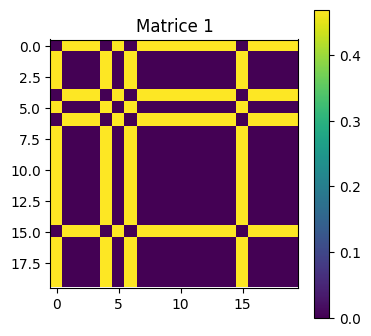

-------------------------------------
Problem 2:
Best: [1 0 1 0 1]...	fitness:0.251	calls:20
Best: [1 1 1 0 1]...	fitness:0.488	calls:20
(MOST DIFFERENT):	0, 0	(without fitness)
(INDIVIDUALS SELECTED):	0, 0	(with fitness)
Best: [0 1 0 0 0]...	fitness:0.524	calls:60


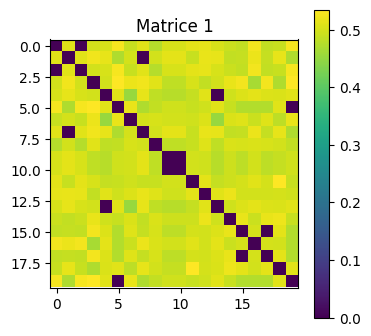

-------------------------------------
Problem 5:
Best: [0 1 1 0 1]...	fitness:0.0975717	calls:20
Best: [1 1 1 1 0]...	fitness:0.104549	calls:20
Best: [0 0 0 0 1]...	fitness:0.194947	calls:20
(MOST DIFFERENT):	0, 0	(without fitness)
(INDIVIDUALS SELECTED):	0, 0	(with fitness)
Best: [1 1 1 1 1]...	fitness:0.202704	calls:100
(MOST DIFFERENT):	0, 0	(without fitness)
(INDIVIDUALS SELECTED):	0, 0	(with fitness)
Best: [0 0 0 1 1]...	fitness:0.206235	calls:280


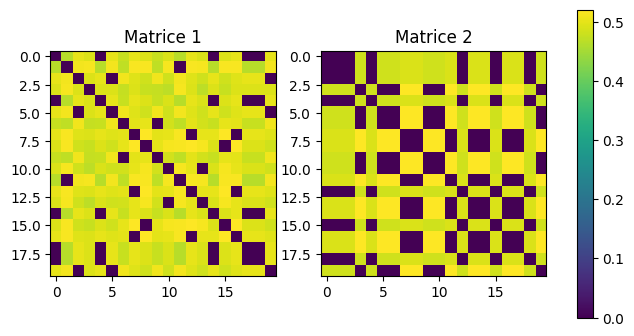

-------------------------------------
Problem 10:
Best: [0 0 0 0 0]...	fitness:0.055679014467	calls:20
Best: [1 0 0 1 1]...	fitness:0.10601266686	calls:20
Best: [0 0 0 0 0]...	fitness:0.10814457011	calls:20
(MOST DIFFERENT):	0, 0	(without fitness)
(INDIVIDUALS SELECTED):	0, 0	(with fitness)
Best: [0 0 0 1 0]...	fitness:0.15344556950000002	calls:60
(MOST DIFFERENT):	0, 0	(without fitness)
(INDIVIDUALS SELECTED):	0, 0	(with fitness)
Best: [0 0 0 1 1]...	fitness:0.1591236794	calls:180
(MOST DIFFERENT):	0, 0	(without fitness)
(INDIVIDUALS SELECTED):	0, 0	(with fitness)
Best: [0 0 1 0 1]...	fitness:0.162011203	calls:1900


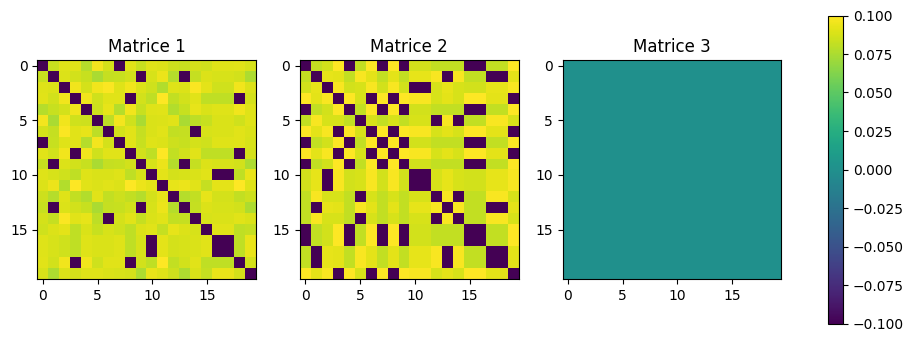

-------------------------------------
Problem	1:	54.00%,	Calls:	2020,	Best found at 	560 fitness calls,	at iteration 27
Problem	2:	52.40%,	Calls:	2020,	Best found at 	60 fitness calls,	at iteration 2
Problem	5:	20.62%,	Calls:	2020,	Best found at 	280 fitness calls,	at iteration 13
Problem	10:	16.20%,	Calls:	2020,	Best found at 	1900 fitness calls,	at iteration 94
-------------------------------------


In [115]:
my_list = list()
found = -1
fitness = None
for prob in problems:
    print(f"Problem {prob}:")
    fitness = lab9_lib.make_problem(prob)
    b, found, i = genetic_algorithm(fitness, select_with_replacement, std_crossover)
    my_list.append((prob, b[1], fitness.calls, found, i))
    print("-------------------------------------")

for m in my_list:
    print(f"Problem\t{m[0]}:\t{m[1]:.2%},\tCalls:\t{m[2]},\tBest found at \t{m[3]} fitness calls,\tat iteration {m[4]}")
print("-------------------------------------")

### Using CYCLIC SHIFT CROSSOVER and Selection based on diversity:

Problem 1:
Best: [0 1 0 1 0]...	fitness:0.501	calls:20
Best: [0 0 0 0 1]...	fitness:0.502	calls:20
Best: [0 1 0 0 0]...	fitness:0.51	calls:20
Best: [0 1 0 0 1]...	fitness:0.517	calls:20
(MOST DIFFERENT):	0, 7	(without fitness)
(INDIVIDUALS SELECTED):	2, 3	(with fitness)
Best: [0 0 0 1 0]...	fitness:0.518	calls:100
(MOST DIFFERENT):	0, 1	(without fitness)
(INDIVIDUALS SELECTED):	0, 1	(with fitness)
Best: [1 0 0 1 1]...	fitness:0.52	calls:120
(MOST DIFFERENT):	1, 3	(without fitness)
(INDIVIDUALS SELECTED):	1, 3	(with fitness)
Best: [1 0 0 1 1]...	fitness:0.522	calls:280
(MOST DIFFERENT):	0, 1	(without fitness)
(INDIVIDUALS SELECTED):	0, 1	(with fitness)
Best: [1 1 1 0 1]...	fitness:0.529	calls:380
(MOST DIFFERENT):	0, 1	(without fitness)
(INDIVIDUALS SELECTED):	0, 1	(with fitness)
Best: [1 1 1 0 0]...	fitness:0.535	calls:380
(MOST DIFFERENT):	0, 1	(without fitness)
(INDIVIDUALS SELECTED):	0, 1	(with fitness)
Best: [1 0 1 0 1]...	fitness:0.536	calls:760
(MOST DIFFERENT):	0, 1	(without fit

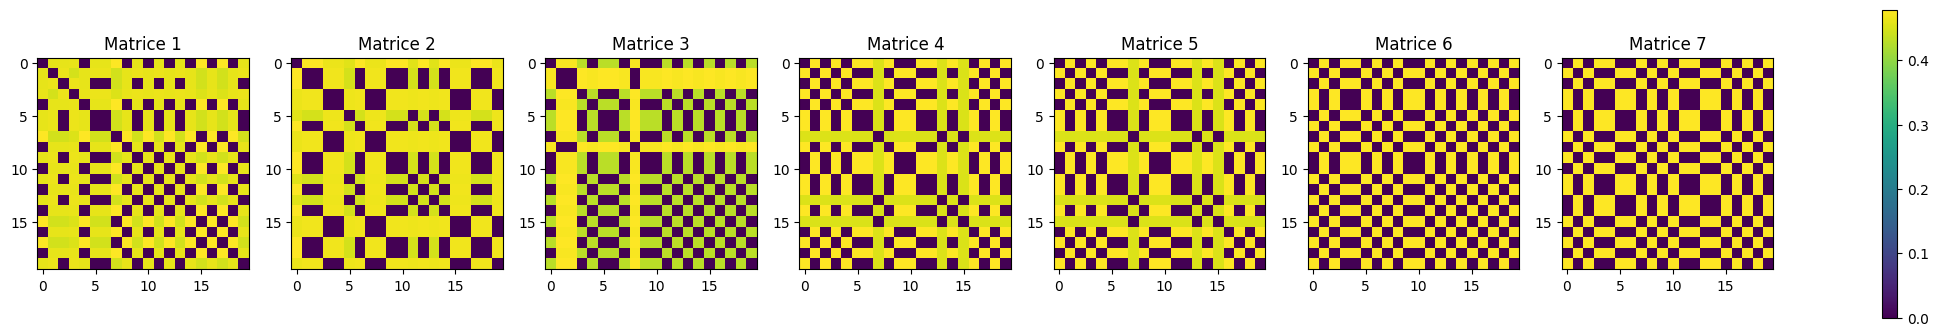

-------------------------------------
Problem 2:
Best: [0 0 1 1 0]...	fitness:0.24659999999999999	calls:20
Best: [1 0 1 0 0]...	fitness:0.2485	calls:20
(MOST DIFFERENT):	7, 13	(without fitness)
(INDIVIDUALS SELECTED):	7, 13	(with fitness)
Best: [1 0 0 0 1]...	fitness:0.2516	calls:140
(MOST DIFFERENT):	1, 3	(without fitness)
(INDIVIDUALS SELECTED):	1, 3	(with fitness)
Best: [1 1 0 1 0]...	fitness:0.2559	calls:600
(MOST DIFFERENT):	0, 3	(without fitness)
(INDIVIDUALS SELECTED):	0, 3	(with fitness)
Best: [1 1 0 0 1]...	fitness:0.2562	calls:900
(MOST DIFFERENT):	0, 1	(without fitness)
(INDIVIDUALS SELECTED):	0, 1	(with fitness)
Best: [1 0 0 1 1]...	fitness:0.512	calls:1020
(MOST DIFFERENT):	0, 2	(without fitness)
(INDIVIDUALS SELECTED):	0, 2	(with fitness)
Best: [0 0 0 1 0]...	fitness:0.526	calls:1240


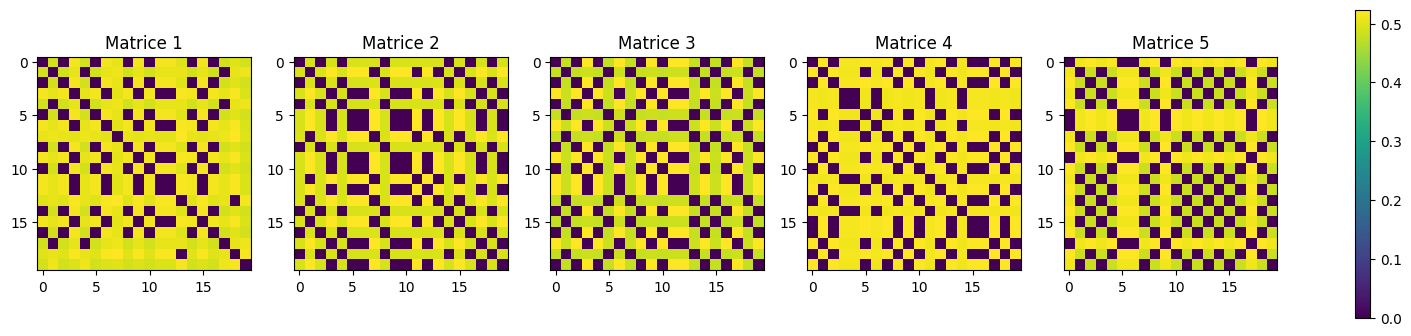

-------------------------------------
Problem 5:
Best: [1 1 0 1 0]...	fitness:0.0947059	calls:20
Best: [1 0 1 0 0]...	fitness:0.19881200000000002	calls:20
Best: [1 1 0 1 1]...	fitness:0.206407	calls:20
(MOST DIFFERENT):	0, 1	(without fitness)
(INDIVIDUALS SELECTED):	0, 1	(with fitness)
Best: [0 0 1 1 0]...	fitness:0.209256	calls:600
(MOST DIFFERENT):	1, 3	(without fitness)
(INDIVIDUALS SELECTED):	1, 3	(with fitness)
Best: [0 1 1 1 0]...	fitness:0.212257	calls:840
(MOST DIFFERENT):	0, 1	(without fitness)
(INDIVIDUALS SELECTED):	0, 1	(with fitness)
Best: [1 1 1 1 1]...	fitness:0.22336799999999998	calls:1260


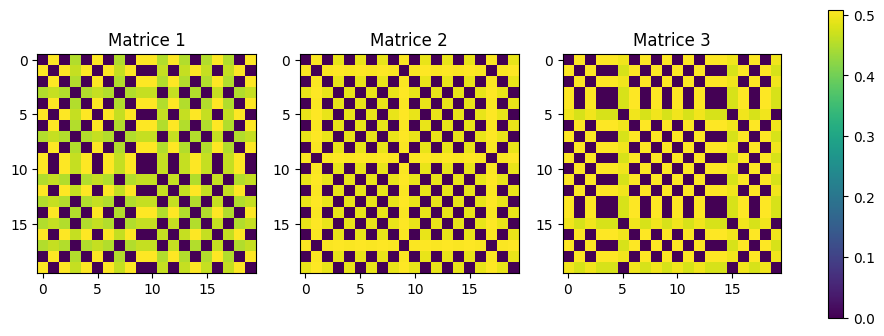

-------------------------------------
Problem 10:
Best: [0 0 0 1 1]...	fitness:0.052144560241999996	calls:20
Best: [0 0 0 1 1]...	fitness:0.054490222796	calls:20
Best: [0 0 1 1 1]...	fitness:0.055011247019	calls:20
Best: [1 0 0 1 1]...	fitness:0.055600358938	calls:20
Best: [1 1 0 1 0]...	fitness:0.10613356786	calls:20
(MOST DIFFERENT):	1, 7	(without fitness)
(INDIVIDUALS SELECTED):	0, 7	(with fitness)
Best: [0 0 1 1 0]...	fitness:0.10622246688	calls:60
(MOST DIFFERENT):	0, 3	(without fitness)
(INDIVIDUALS SELECTED):	0, 3	(with fitness)
Best: [1 1 0 1 0]...	fitness:0.1711234829	calls:80


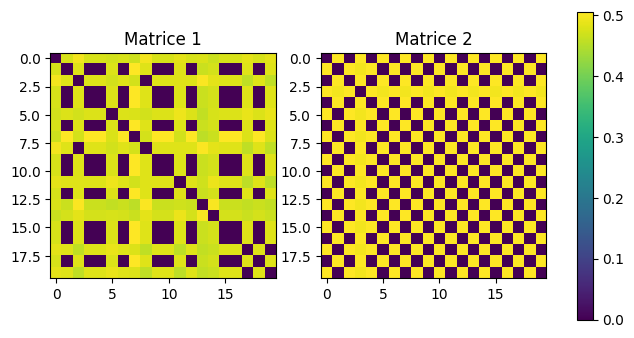

-------------------------------------
Problem	1:	54.40%,	Calls:	2020,	Best found at 	860 fitness calls,	at iteration 42
Problem	2:	52.60%,	Calls:	2020,	Best found at 	1240 fitness calls,	at iteration 61
Problem	5:	22.34%,	Calls:	2020,	Best found at 	1260 fitness calls,	at iteration 62
Problem	10:	17.11%,	Calls:	2020,	Best found at 	80 fitness calls,	at iteration 3
-------------------------------------


In [116]:
my_list = list()
found = -1
fitness = None
for prob in problems:
    print(f"Problem {prob}:")
    fitness = lab9_lib.make_problem(prob)
    b, found, i = genetic_algorithm(fitness, diversity_selection, crossover_cyclic_shift)
    my_list.append((prob, b[1], fitness.calls, found, i))
    print("-------------------------------------")

for m in my_list:
    print(f"Problem\t{m[0]}:\t{m[1]:.2%},\tCalls:\t{m[2]},\tBest found at \t{m[3]} fitness calls,\tat iteration {m[4]}")
print("-------------------------------------")

In [117]:
for i, prob in enumerate(problems):
    print(f"Problem {prob}:")
    Best = None
    fitness = lab9_lib.make_problem(prob)
    for n in range(10):
        ind = choices([0, 1], k=1000)
        fit = fitness(ind)
        if Best is None or fit > Best[1]:
            Best = ind, fit
        print(f"{''.join(str(g) for g in ind[0:5])}... | {fit:.2%}")

    print(Best[1])
    print(fitness.calls)

    print("-------------------------------------")


Problem 1:
11110... | 48.40%
10110... | 49.30%
00010... | 47.00%
01000... | 49.50%
10111... | 49.40%
00110... | 53.90%
11000... | 47.30%
00100... | 49.70%
01110... | 49.90%
00101... | 51.40%
0.539
10
-------------------------------------
Problem 2:
00000... | 21.81%
00011... | 24.00%
00111... | 23.54%
10010... | 48.60%
11010... | 23.10%
00010... | 23.54%
01001... | 24.34%
01000... | 22.47%
11000... | 23.61%
00010... | 22.80%
0.486
10
-------------------------------------
Problem 5:
01101... | 19.51%
01000... | 9.70%
01110... | 9.44%
01111... | 9.35%
10101... | 9.94%
11000... | 10.41%
00000... | 9.29%
00101... | 9.29%
01111... | 9.77%
11010... | 9.74%
0.195053
10
-------------------------------------
Problem 10:
11010... | 4.90%
11001... | 5.47%
01100... | 5.84%
10011... | 5.56%
11101... | 5.02%
11011... | 4.73%
11000... | 4.82%
01011... | 5.18%
00010... | 4.90%
10001... | 5.29%
0.058401234572
10
-------------------------------------


In [118]:
fitness = lab9_lib.make_problem(1)
for n in range(10):
    ind = choices([0, 1], k=50)
    print(f"{''.join(str(g) for g in ind)}: {fitness(ind):.2%}")

print(fitness.calls)

01001110011000001111110011011110101100100100000011: 50.00%
11110111010101011001110011111000011101101101111111: 68.00%
00110001001010111111101111100000110010110001110111: 56.00%
10111000100101000100011001000100111011100100101000: 42.00%
00001011110011110000011101011111101110110101010100: 56.00%
01110111011111010001100001001000111110111001000100: 52.00%
01110100100001000000011100111100001011100100111111: 48.00%
10110101011011001011110101010000111011001111001000: 54.00%
11000001111000111100010011010110001001101110111000: 50.00%
01101000101110011000001110011100101110010011000001: 46.00%
10


## Island Model

In [119]:
l = 1000
problems = [1, 2, 5, 10]
half_pop_size = 10
µ = 2 * half_pop_size
iterations = 100

def i_diversity_selection(population):
  # find the individuals with 
  # the highest fitness and the highest diversity
  max_div = 0
  i1, i2 = None, None
  for i, p1 in enumerate(population):
      for j, p2 in enumerate(population):
          if i < j:
            div = (compute_diversity(p1[0], p2[0]) + p1[1] + p2[1]) / 3
            if div > max_div:
              max_div = div
              i1, i2 = p1, p2
  return i1, i2

def evolve(population, fitness):
  Best = None
  q = list()
  for _ in range(µ//2):
      # Select parents
      parent_a, parent_b = i_diversity_selection(population)
      # Crossover
      child_a, child_b = crossover_cyclic_shift(copy(parent_a), copy(parent_b))
      # Mutate
      mutated_a = mutate(child_a)
      mutated_b = mutate(child_b)
      q.append(mutated_a)
      q.append(mutated_b)
  population = evaluate_population(q, fitness)
  idx_p = None
  for i, p in enumerate(population):
    if Best is None or p[1] > Best[1]:
      Best = p
      idx_p = i
  return Best, idx_p

def island_method(fitness, n_islands=2):
  populations = []
  Best = None
  tmp_best = None

  for _ in range(n_islands):
    populations.append(init_population())
  
  for _ in range(iterations):
    for i in range(n_islands):
       for j in range(n_islands):
          if i != j:
            i1, idx_1 = evolve(populations[i], fitness)
            i2, idx_2 = evolve(populations[j], fitness)
            populations[i][idx_1], populations[j][idx_2] = i2, i1  # exchange of the individual
            tmp_best  = max([i1, i2], key=lambda i: i[1])
            if Best is None or tmp_best[1] > Best[1]:
               Best = tmp_best
  return Best

for p in problems:
  fitness = lab9_lib.make_problem(p)
  b = island_method(fitness)
  print(f"Problem {p}:{fitness.calls}, best:{b[1]:.2%}")


Problem 1:8000, best:54.40%
Problem 2:8000, best:52.00%
Problem 5:8000, best:31.24%
Problem 10:8000, best:25.43%
